In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd 'drive/MyDrive/Uni/UniPD/HumanDataProject/Code'

/content/drive/MyDrive/Uni/UniPD/HumanDataProject/Code


In [3]:
!pip install tensorflow-io
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.2 MB/s eta 0:00:00


In [4]:
import sys
import warnings
import threading
import subprocess
import psutil
#import random
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix,accuracy_score

import time
import os
import numpy as np
from config import PREPROCESSING_PATH,DATASET_SPLIT_PATH
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from scipy.io import wavfile
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from scipy.stats import mode



from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [5]:
warnings.filterwarnings(action='ignore', category=wavfile.WavFileWarning)

In [6]:
sys.path.append(PREPROCESSING_PATH)

In [7]:
import preprocessing_tf
import conformer_ensemble
import evaluation

In [8]:

from conformer_ensemble import ConformerBlock, FeedForwardModule, RelativePositionMultiHeadAttention, ConvolutionalModule1D

In [9]:
# Set the seed for Python's random module
#random.seed(42)

# Set the seed for NumPy
#np.random.seed(42)

# Set the global and operation-level seed for TensorFlow
#tf.random.set_seed(42)


In [10]:
print("Number of GPU:", len(tf.config.list_physical_devices('GPU')))
print("Version:", tf.__version__)

Number of GPU: 1
Version: 2.15.0


# Dataset loading

To improve training efficiency, the dataset is pre-loaded into runtime, avoiding slow read speeds from the drive. It's already divided into train, validation, and test folders.

In [11]:
%cd /content/drive/MyDrive/Uni/UniPD/HumanDataProject

/content/drive/MyDrive/Uni/UniPD/HumanDataProject


In [12]:
!unzip project_data_split.zip -d /content/data

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: /content/data/project_data_split/validation/off/439c84f4_nohash_3.wav  
  inflating: /content/data/project_data_split/validation/off/44c201dd_nohash_0.wav  
  inflating: /content/data/project_data_split/validation/off/44c201dd_nohash_1.wav  
  inflating: /content/data/project_data_split/validation/off/45692b02_nohash_0.wav  
  inflating: /content/data/project_data_split/validation/off/45692b02_nohash_1.wav  
  inflating: /content/data/project_data_split/validation/off/45692b02_nohash_2.wav  
  inflating: /content/data/project_data_split/validation/off/45692b02_nohash_3.wav  
  inflating: /content/data/project_data_split/validation/off/471a0925_nohash_0.wav  
  inflating: /content/data/project_data_split/validation/off/471a0925_nohash_1.wav  
  inflating: /content/data/project_data_split/validation/off/471a0925_nohash_2.wav  
  inflating: /content/data/project_data_split/validation/off/471a0925_nohash_3.wav 

In [13]:
DATASET_SPLIT_PATH = "/content/data/project_data_split"

# Preprocessing


The preprocessing steps outlined below are used to prepare the data for the Conformer model:

*   All non-keywords are categorized into a single class named "unknown" to simplify the multi-class classification problem by reducing the number of classes.
*   Data padding is applied to ensure a consistent input shape across all samples.
*   Noise is added to enhance realism in the dataset and to avoid overfitting
*   The audio is transformed into MFCC (Mel Frequency Cepstral Coefficients) spectrograms for analysis.

In [17]:
train_df = preprocessing_tf.get_file_list(os.path.join(DATASET_SPLIT_PATH,"train"))
val_df= preprocessing_tf.get_file_list(os.path.join(DATASET_SPLIT_PATH,"validation"))
#val_df= preprocessing_tf.get_file_list(os.path.join(DATASET_SPLIT_PATH,"test"))

In [18]:
file_paths = tf.constant(train_df['filepath'].values)
labels = tf.constant(train_df['mapped_label'].values)

In [19]:
# Create a StringLookup layer and transform the class names to numeric labels
label_lookup = tf.keras.layers.StringLookup(num_oov_indices=0)
label_lookup.adapt(labels)
numeric_labels = label_lookup(labels)

#train dataset
train_dataset = tf.data.Dataset.from_tensor_slices((file_paths, numeric_labels))

In [20]:
#create validation dataset
file_paths_val = tf.constant(val_df['filepath'].values)
labels_val = tf.constant(val_df['mapped_label'].values)
numeric_labels_val = label_lookup(labels_val)
validation_dataset = tf.data.Dataset.from_tensor_slices((file_paths_val, numeric_labels_val))

In [21]:
#call preprocessing function and define which preprocessing steps to do
train_spectrogram_ds = train_dataset.map(lambda fp, lbl: preprocessing_tf.preprocess_map_new(fp, lbl,noise=True, mfcc=True),
                               num_parallel_calls=tf.data.AUTOTUNE)
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)

val_spectrogram_ds = validation_dataset.map(lambda fp, lbl: preprocessing_tf.preprocess_map_new(fp, lbl,noise=True, mfcc=True),
                               num_parallel_calls=tf.data.AUTOTUNE)

val_spectrogram_ds= val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Padding shape: (16000,)
/content/data/project_data_split/_background_noise_/white_noise.wav
Noisy shape: (16000,)
log_mel_spectrogram shape: (98, 40)
Mfcc shape: (98, 40, 1)
Padding shape: (16000,)
/content/data/project_data_split/_background_noise_/white_noise.wav
Noisy shape: (16000,)
log_mel_spectrogram shape: (98, 40)
Mfcc shape: (98, 40, 1)


In [22]:
#define the batch size
batch_size = 32
train_spectrogram_ds = train_spectrogram_ds.batch(batch_size)
val_spectrogram_ds = val_spectrogram_ds.batch(batch_size)

In [23]:
input_shape =train_spectrogram_ds.element_spec[0].shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_lookup.get_vocabulary())
print('Number of labels:', num_labels)

Input shape: (98, 40, 1)
Number of labels: 26


# Conformer Ensemble

The idea behind ensemble models is to combine several simpler models to enhance prediction accuracy. This method is effective because it leverages the strengths of each model, resulting in more precise and dependable predictions than a single model could provide. That an ensemble approach can be effective for speach recognition is for example shown in [Gitman23]. To explore the potential for improving predictions of the Conformer model, we plan to employ an ensemble of different Conformer models. Our approach will involve using three distinct Conformer models and determining the final predictions through majority voting.

Given that our focus remains on keyword spotting, we aim to maintain the ensemble's complexity at a manageable level. Training three separate models is likely to require more time and resources than training a single model. Consequently, we have imposed a limit that each individual model can have a maximum of 500K parameters, ensuring that the entire ensemble does not exceed 1.5 million parameters.

## Create Confomer models

All models in our ensemble will be Conformer models, but each of the three will have a different configuration, including variations in model dimension, kernel size, filters, etc. as for an ensemble model to effectively improve accuracy, the included models can not be too similar.

As for our single conformer model the conformer models follow the architecture described in [Gulati20].

In [14]:
%cd /content/drive/MyDrive/Uni/UniPD/HumanDataProject

/content/drive/MyDrive/Uni/UniPD/HumanDataProject


In [22]:
EPOCHS = 100

### Conformer Model 1

In [ ]:
Value             |Best Value So Far |Hyperparameter
48                |60                |d_model
32                |40                |filters
8                 |8                 |num_heads
18                |2                 |kernel_size
0.3               |0.1               |dropout_rate

In [23]:
#create first model
model1 = conformer_ensemble.build_model(input_shape, num_labels, d_model=90, num_heads=4, kernel_size=4, dropout_rate=0.2,subsample_stride=(1,1))
#model1 = conformer_ensemble.build_model(input_shape, num_labels, d_model=24, num_heads=4, kernel_size=2, dropout_rate=0.2,subsample_stride=(1,1))

In [24]:
model1.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.98, epsilon=1e-9),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [25]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 98, 40, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 98, 40, 90)        1530      
                                                                 
 batch_normalization (Batch  (None, 98, 40, 90)        360       
 Normalization)                                                  
                                                                 
 reshape (Reshape)           (None, 98, 3600)          0         
                                                                 
 time_distributed (TimeDist  (None, 98, 90)            324090    
 ributed)                                                        
                                                                 
 dropout (Dropout)           (None, 98, 90)            0     

In [26]:
#gpu usage logging
stop_event = threading.Event()
log_file_path = 'gpu_log_files/gpu_usage_conformer_ensemble_model1.txt'
interval = 30

In [27]:
#training callbacks
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

In [28]:
#start gpu logging
thread = threading.Thread(target=evaluation.log_gpu_usage, args=(log_file_path, stop_event, interval), daemon=True)
thread.start()

In [29]:
#train first model and track training time cpu and gpu usage
start_time = time.time()

history1 = model1.fit(train_spectrogram_ds,
                      validation_data=val_spectrogram_ds,
                      epochs=EPOCHS,
                      callbacks=[early_stop_callback, reduce_LR],
                      verbose=1)

end_time = time.time()
cpu_usage_train = evaluation.get_system_ram_usage()
stop_event.set()
thread.join()
train_time1 = end_time - start_time
print(f"CPU Usage: {cpu_usage_train} GB")
print(f"Total training time: {train_time1} seconds")

Epoch 1/100
2652/2652 [==============================] - 497s 165ms/step - loss: 0.8950 - sparse_categorical_accuracy: 0.7264 - val_loss: 2.9365 - val_sparse_categorical_accuracy: 0.3923 - lr: 1.0000e-04
Epoch 2/100
2652/2652 [==============================] - 56s 21ms/step - loss: 0.5262 - sparse_categorical_accuracy: 0.8429 - val_loss: 2.3997 - val_sparse_categorical_accuracy: 0.4873 - lr: 1.0000e-04
Epoch 3/100
2652/2652 [==============================] - 55s 21ms/step - loss: 0.4033 - sparse_categorical_accuracy: 0.8787 - val_loss: 2.1093 - val_sparse_categorical_accuracy: 0.5084 - lr: 1.0000e-04
Epoch 4/100
2652/2652 [==============================] - 55s 21ms/step - loss: 0.3334 - sparse_categorical_accuracy: 0.8983 - val_loss: 1.9906 - val_sparse_categorical_accuracy: 0.5574 - lr: 1.0000e-04
Epoch 5/100
2652/2652 [==============================] - 55s 21ms/step - loss: 0.2998 - sparse_categorical_accuracy: 0.9085 - val_loss: 1.7601 - val_sparse_categorical_accuracy: 0.5871 - lr:

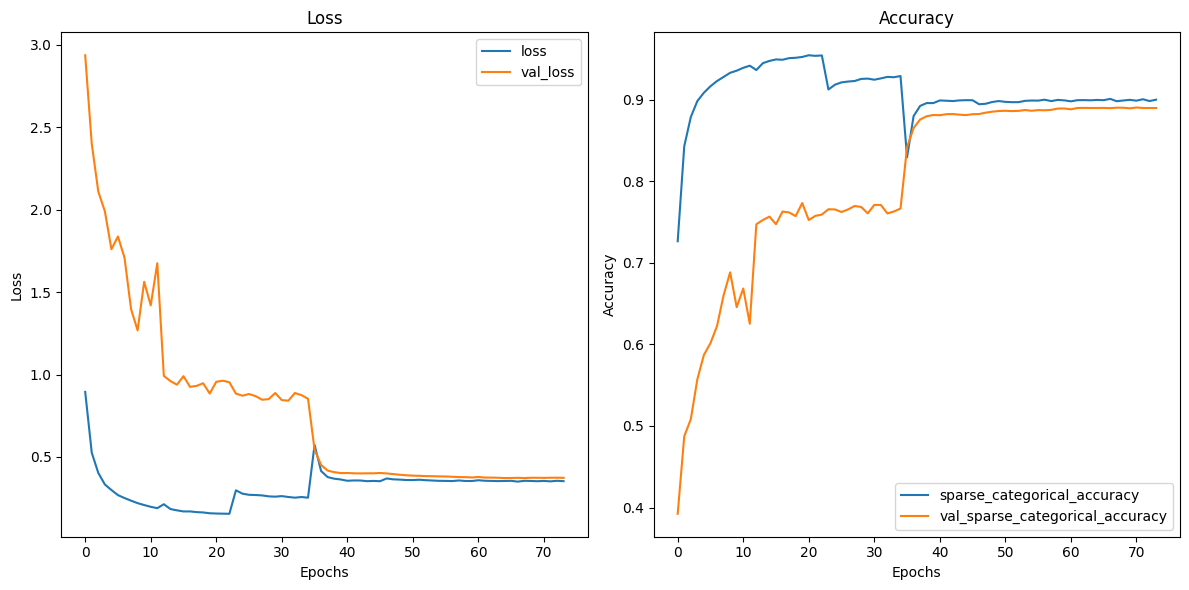

In [30]:
evaluation.plot_fit_history(history1, ['loss', 'val_loss'],['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'])

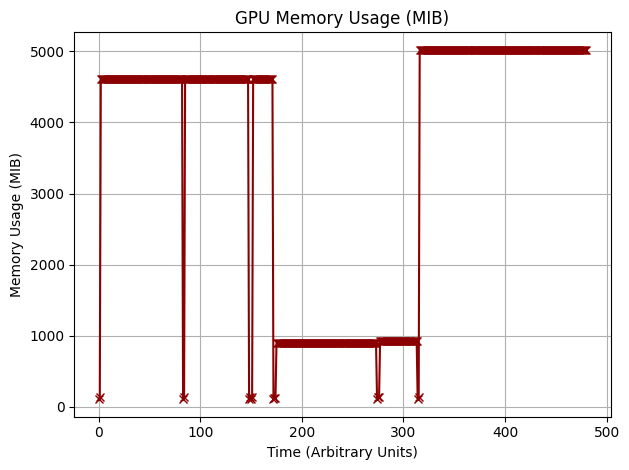

In [31]:
#get gpu usage from the log files
df_gpu_train1 = evaluation.get_gpu_usage(log_file_path)

### Conformer Model 2

In [32]:
#create second model
model2 = conformer_ensemble.build_model(input_shape, num_labels, d_model=64, num_heads=2, kernel_size=16, dropout_rate=0.3,subsample_stride=(1,1))

In [33]:
model2.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.98, epsilon=1e-9),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [34]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 98, 40, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 40, 64)        1088      
                                                                 
 batch_normalization_2 (Bat  (None, 98, 40, 64)        256       
 chNormalization)                                                
                                                                 
 reshape_1 (Reshape)         (None, 98, 2560)          0         
                                                                 
 time_distributed_1 (TimeDi  (None, 98, 64)            163904    
 stributed)                                                      
                                                                 
 dropout_7 (Dropout)         (None, 98, 64)            0   

In [35]:
#gpu logging
stop_event = threading.Event()
log_file_path = 'gpu_log_files/gpu_usage_conformer_ensemble_model2.txt'
interval = 30

In [36]:
#traib callbacks
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

In [37]:
#start gpu logging
thread = threading.Thread(target=evaluation.log_gpu_usage, args=(log_file_path, stop_event, interval), daemon=True)
thread.start()

In [38]:
#train second model and track training time cpu and gpu usage
start_time = time.time()

history2 = model2.fit(train_spectrogram_ds,
                      validation_data=val_spectrogram_ds,
                      epochs=EPOCHS,
                      callbacks=[early_stop_callback, reduce_LR],
                      verbose=1)

end_time = time.time()
cpu_usage_train = evaluation.get_system_ram_usage() #get cpu usage
stop_event.set() #stopp gpu logging
thread.join()
train_time2 = end_time - start_time #train time
print(f"CPU Usage: {cpu_usage_train} GB")
print(f"Total training time: {train_time2} seconds")

Epoch 1/100
2652/2652 [==============================] - 60s 19ms/step - loss: 0.9656 - sparse_categorical_accuracy: 0.7249 - val_loss: 3.0903 - val_sparse_categorical_accuracy: 0.3829 - lr: 1.0000e-04
Epoch 2/100
2652/2652 [==============================] - 49s 18ms/step - loss: 0.5356 - sparse_categorical_accuracy: 0.8485 - val_loss: 2.1887 - val_sparse_categorical_accuracy: 0.5002 - lr: 1.0000e-04
Epoch 3/100
2652/2652 [==============================] - 47s 18ms/step - loss: 0.3931 - sparse_categorical_accuracy: 0.8875 - val_loss: 1.9925 - val_sparse_categorical_accuracy: 0.5596 - lr: 1.0000e-04
Epoch 4/100
2652/2652 [==============================] - 46s 18ms/step - loss: 0.3240 - sparse_categorical_accuracy: 0.9062 - val_loss: 2.0367 - val_sparse_categorical_accuracy: 0.5429 - lr: 1.0000e-04
Epoch 5/100
2652/2652 [==============================] - 46s 17ms/step - loss: 0.2814 - sparse_categorical_accuracy: 0.9171 - val_loss: 1.6297 - val_sparse_categorical_accuracy: 0.6165 - lr: 1

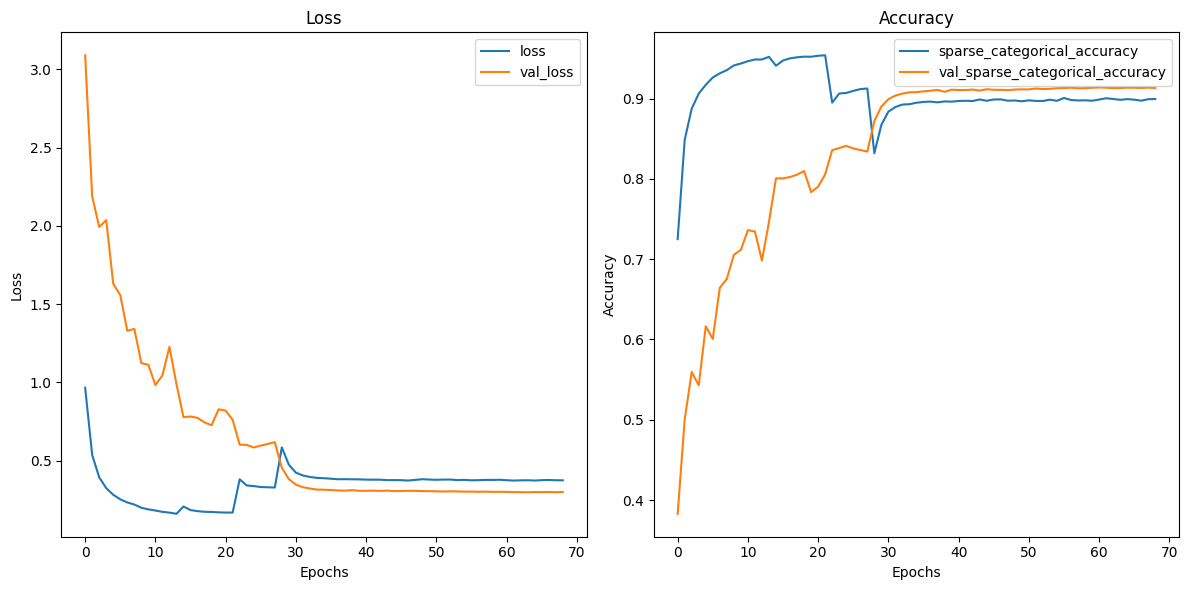

In [39]:
evaluation.plot_fit_history(history2, ['loss', 'val_loss'],['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'])

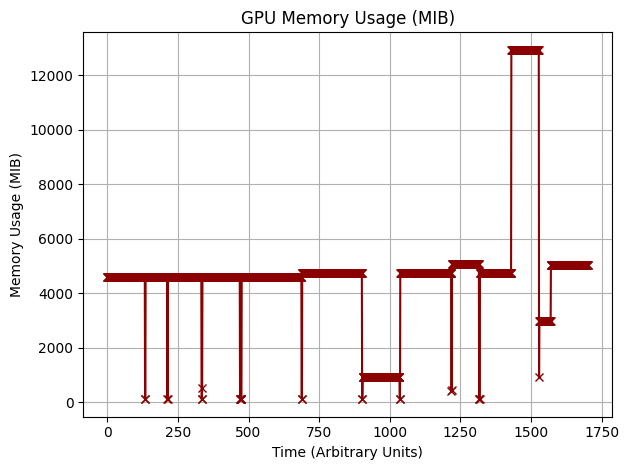

In [40]:
#plot and get gpu usage from the logfiles
df_gpu_train2 = evaluation.get_gpu_usage(log_file_path)

### Conformer Model 3

In [41]:
#create third model
model3 = conformer_ensemble.build_model(input_shape, num_labels, d_model=54, num_heads=8, kernel_size=12, dropout_rate=0.4,subsample_stride=(1,1))

In [42]:
model3.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.98, epsilon=1e-9),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [43]:
model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 98, 40, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 98, 40, 54)        918       
                                                                 
 batch_normalization_4 (Bat  (None, 98, 40, 54)        216       
 chNormalization)                                                
                                                                 
 reshape_2 (Reshape)         (None, 98, 2160)          0         
                                                                 
 time_distributed_2 (TimeDi  (None, 98, 54)            116694    
 stributed)                                                      
                                                                 
 dropout_14 (Dropout)        (None, 98, 54)            0   

In [44]:
#gpu logging configuration
stop_event = threading.Event()
log_file_path = 'gpu_log_files/gpu_usage_conformer_ensemble_model3.txt'
interval = 30

In [45]:
#callbacks for model training
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

In [46]:
#thread for gpu logging
thread = threading.Thread(target=evaluation.log_gpu_usage, args=(log_file_path, stop_event, interval), daemon=True)
thread.start()

In [47]:
#train third model and track training time cpu and gpu usage

start_time = time.time()

history3 = model3.fit(train_spectrogram_ds,
                      validation_data=val_spectrogram_ds,
                      epochs=EPOCHS,
                      callbacks=[early_stop_callback, reduce_LR],
                      verbose=1)

end_time = time.time()
cpu_usage_train = evaluation.get_system_ram_usage() #train cpu usage
stop_event.set() #train gpu usage
thread.join()
train_time3 = end_time - start_time #train time
print(f"CPU Usage: {cpu_usage_train} GB")
print(f"Total training time: {train_time3} seconds")

Epoch 1/100
2652/2652 [==============================] - 58s 18ms/step - loss: 1.1821 - sparse_categorical_accuracy: 0.6505 - val_loss: 3.4434 - val_sparse_categorical_accuracy: 0.3527 - lr: 1.0000e-04
Epoch 2/100
2652/2652 [==============================] - 50s 19ms/step - loss: 0.6952 - sparse_categorical_accuracy: 0.7969 - val_loss: 2.7909 - val_sparse_categorical_accuracy: 0.4501 - lr: 1.0000e-04
Epoch 3/100
2652/2652 [==============================] - 49s 19ms/step - loss: 0.5131 - sparse_categorical_accuracy: 0.8488 - val_loss: 2.6980 - val_sparse_categorical_accuracy: 0.4607 - lr: 1.0000e-04
Epoch 4/100
2652/2652 [==============================] - 50s 19ms/step - loss: 0.4300 - sparse_categorical_accuracy: 0.8737 - val_loss: 2.3945 - val_sparse_categorical_accuracy: 0.5233 - lr: 1.0000e-04
Epoch 5/100
2652/2652 [==============================] - 51s 19ms/step - loss: 0.3768 - sparse_categorical_accuracy: 0.8880 - val_loss: 1.8903 - val_sparse_categorical_accuracy: 0.5836 - lr: 1

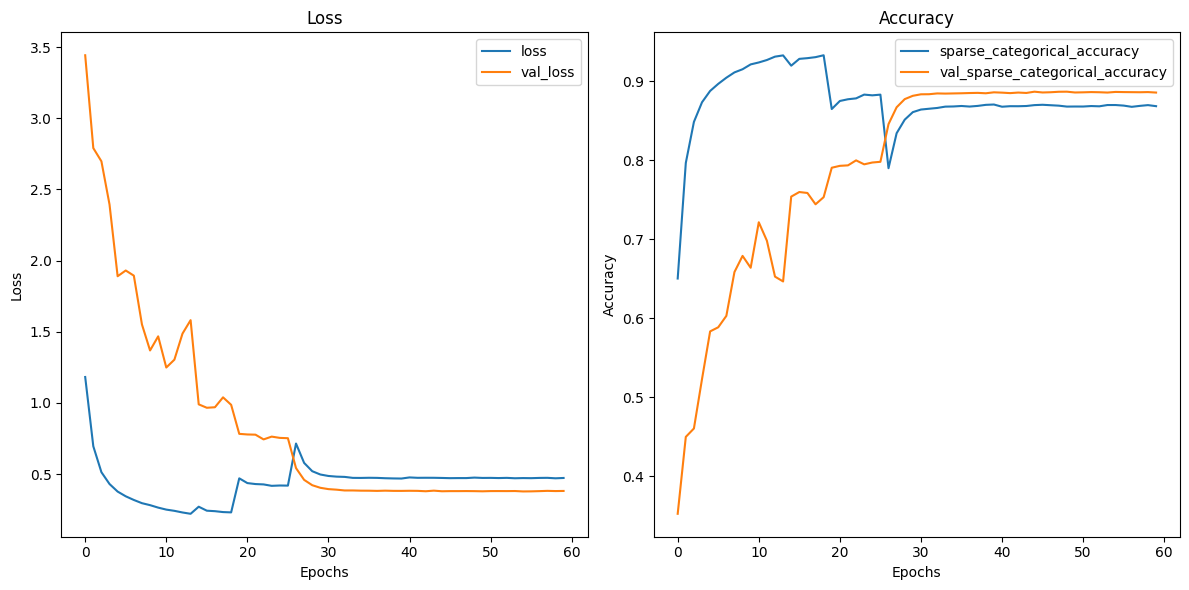

In [48]:
evaluation.plot_fit_history(history3, ['loss', 'val_loss'],['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'])

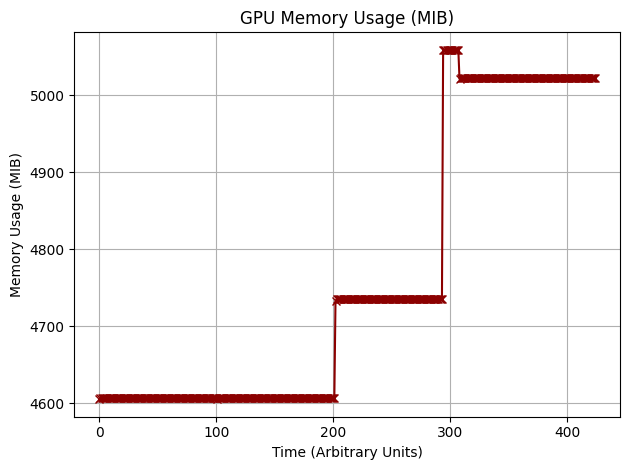

In [49]:
#get the gpu usage from the log files
df_gpu_train3 = evaluation.get_gpu_usage(log_file_path)

In [56]:
# save all 3 trained models
model1.save('Models/ensembel_model1', save_format='tf')
model2.save('Models/ensembel_model2', save_format='tf')
model3.save('Models/ensembel_model3', save_format='tf')

In [15]:
model1 = tf.keras.models.load_model('Models/ensembel_model1')
model2 = tf.keras.models.load_model('Models/ensembel_model2')
model3 = tf.keras.models.load_model('Models/ensembel_model3')

In [21]:
#in case models already exist load the models

#for laoding the self created conformer components
custom_objects = {
    'ConformerBlock': ConformerBlock,
    'FeedForwardModule': FeedForwardModule,
    'RelativePositionMultiHeadAttention': RelativePositionMultiHeadAttention,
    'ConvolutionalModule1D': ConvolutionalModule1D,
}

model_path = 'Models/ensembel_model1.keras'
model1 = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

model_path = 'Models/ensembel_model2.keras'
model2 = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

model_path = 'Models/ensembel_model3.keras'
model3 = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

# Evaluation

There are various methods for integrating models into an ensemble; we plan to explore these by employing both majority voting and confidence-based predictions. Another approach could involve training a meta-model to combine the predictions of the three models. However, this would increase complexity and processing time, which we aim to minimize, hence we have decided against this option. In addition, we will assess the performance of each individual model to determine if the ensemble provides superior results on the test dataset compared to any single model. The preprocessing steps applied to the training and validation datasets will be consistently used for the test dataset as well.

In [46]:
#create test dataset
test_df = preprocessing_tf.get_file_list(os.path.join(DATASET_SPLIT_PATH,"test"))
file_paths_test = tf.constant(test_df['filepath'].values)
labels_test = tf.constant(test_df['mapped_label'].values)
numeric_labels_test = label_lookup(labels_test)
test_dataset = tf.data.Dataset.from_tensor_slices((file_paths_test, numeric_labels_test))


In [47]:
test_spectrogram_ds = test_dataset.map(lambda fp, lbl: preprocessing_tf.preprocess_map_new(fp, lbl,mfcc=True,noise=True),
                               num_parallel_calls=tf.data.AUTOTUNE)

Padding shape: (16000,)
log_mel_spectrogram shape: (98, 40)
Mfcc shape: (98, 40, 1)


In [48]:
batch_size = 32
test_spectrogram_ds = test_spectrogram_ds.batch(batch_size)

## Majority Vote

In [49]:
#set up gpu usage logging for testing
stop_event = threading.Event()
log_file_path = 'gpu_log_files/gpu_usage_conformer_ensemble_model_test.txt'
interval = 10

In [50]:
thread = threading.Thread(target=evaluation.log_gpu_usage, args=(log_file_path, stop_event, interval), daemon=True)
thread.start()

In [51]:
#create the predictions for the train dataset with all 3 models and measure time, cpu and gpu usage
start_time = time.time()


predictions_model1 = model1.predict(test_spectrogram_ds)
predictions_model2 = model2.predict(test_spectrogram_ds)
predictions_model3 = model3.predict(test_spectrogram_ds)
labels_model1 = np.argmax(predictions_model1, axis=1)
labels_model2 = np.argmax(predictions_model2, axis=1)
labels_model3 = np.argmax(predictions_model3, axis=1)
stacked_predictions = np.stack([labels_model1, labels_model2, labels_model3], axis=1)
majority_vote_labels = mode(stacked_predictions, axis=1)[0].flatten()

end_time = time.time()
cpu_usage_test = evaluation.get_system_ram_usage()
stop_event.set()
thread.join()

total_time_test = end_time - start_time
print(f"Total testing time: {total_time_test} seconds")

344/344 [==============================] - 15s 43ms/step
Total testing time: 51.433398485183716 seconds


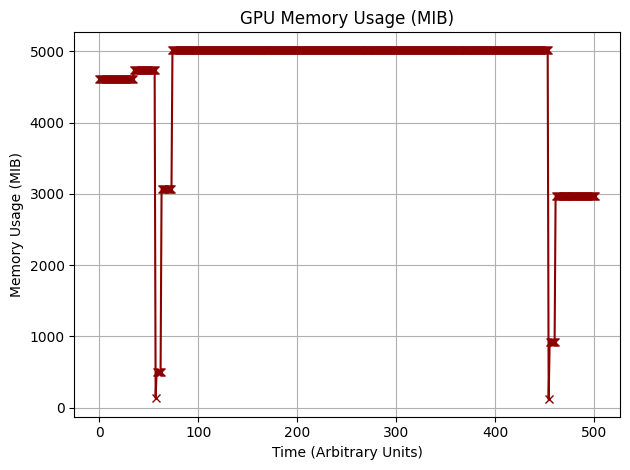

In [52]:
# get the gpu usage from the logging
df_gpu_test = evaluation.get_gpu_usage(log_file_path)

In [53]:
def get_error_metrics(model_name, true_labels, predicted_classes):

    #predicted_classes = tf.argmax(y_pred_logits, axis=1)

    precision = precision_score(true_labels, predicted_classes, average='macro')
    recall = recall_score(true_labels, predicted_classes, average='macro')
    f1 = f1_score(true_labels, predicted_classes, average='macro')
    accuracy = accuracy_score(true_labels, predicted_classes)

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    #cross_entropy_loss = loss_fn(true_labels, predicted_classes).numpy()

    metrics_data = {
        'Model Name': [model_name],  # This creates a single-row DataFrame
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1],
        'Accuracy': [accuracy]
 #       'Cross-Entropy Loss': [cross_entropy_loss]
    }

    # Create the DataFrame
    metrics_df = pd.DataFrame(metrics_data)

    return metrics_df

In [54]:
true_labels = np.concatenate([y for x, y in test_spectrogram_ds], axis=0)
#wahrscheinlich error here
metrics_df_ensemble_maj = get_error_metrics("Conformer ensemble majority vote", true_labels, majority_vote_labels)
metrics_df_ensemble_maj.head()

,Model Name,Precision,Recall,F1 Score,Accuracy
0,Conformer ensemble majority vote,0.895685,0.826013,0.843624,0.850432


## Confidence based

In [55]:
start_time = time.time()

# Get the prediction probabilities for each model
probabilities_model1 = model1.predict(test_spectrogram_ds)
probabilities_model2 = model2.predict(test_spectrogram_ds)
probabilities_model3 = model3.predict(test_spectrogram_ds)

# Find the model with the highest confidence for each class and each instance
confidences = np.max(np.stack([probabilities_model1, probabilities_model2, probabilities_model3]), axis=2)

# Determine the index of the model with the highest confidence for each instance
model_indices_with_highest_confidence = np.argmax(confidences, axis=0)

# Prepare an empty array to hold the final confidence-based predictions
confidence_based_predictions = np.empty(model_indices_with_highest_confidence.shape, dtype=int)

# For each instance, select the prediction with the highest confidence
for i, model_index in enumerate(model_indices_with_highest_confidence):
    selected_model_predictions = [probabilities_model1[i], probabilities_model2[i], probabilities_model3[i]][model_index]
    confidence_based_predictions[i] = np.argmax(selected_model_predictions)

end_time = time.time()
total_time_test = end_time - start_time
print(f"Total testing time: {total_time_test} seconds")

344/344 [==============================] - 15s 43ms/step
Total testing time: 55.98139977455139 seconds


In [56]:
metrics_df_ensemble_con = get_error_metrics("Conformer ensemble confidence based", true_labels, majority_vote_labels)
metrics_df_ensemble_con.head()


,Model Name,Precision,Recall,F1 Score,Accuracy
0,Conformer ensemble confidence based,0.895685,0.826013,0.843624,0.850432


## Individual models

In [57]:
#check the performance of the individual models
metrics_df1 = evaluation.get_error_metrics("Conformer model 1", true_labels, predictions_model1)
metrics_df2 = evaluation.get_error_metrics("Conformer model 2", true_labels, predictions_model2)
metrics_df3 = evaluation.get_error_metrics("Conformer model 3", true_labels, predictions_model3)

In [58]:
#get performance overview over all models
metrics_df = pd.concat([metrics_df1, metrics_df2, metrics_df3, metrics_df_ensemble_maj,metrics_df_ensemble_con], ignore_index=True)
metrics_df.head()

,Model Name,Precision,Recall,F1 Score,Accuracy,Cross-Entropy Loss
0,Conformer model 1,0.865119,0.804621,0.816930,0.822899,2.538062
1,Conformer model 2,0.886727,0.832624,0.849247,0.852612,2.506228
2,Conformer model 3,0.851428,0.801665,0.807485,0.823898,2.530629
3,Conformer ensemble majority vote,0.895685,0.826013,0.843624,0.850432,NaN
4,Conformer ensemble confidence based,0.895685,0.826013,0.843624,0.850432,NaN


# Summary

In [59]:
total_time_train = train_time1 + train_time2 + train_time3


mean_train = (df_gpu_train1['Memory Usage (MiB)'].mean() + df_gpu_train2['Memory Usage (MiB)'].mean() + df_gpu_train3['Memory Usage (MiB)'].mean())/3
mean_test = df_gpu_test['Memory Usage (MiB)'].mean()
max_train = max(df_gpu_train1['Memory Usage (MiB)'].max(),df_gpu_train2['Memory Usage (MiB)'].max(),df_gpu_train3['Memory Usage (MiB)'].max())
max_test = df_gpu_test['Memory Usage (MiB)'].max()

total_params = model1.count_params() + model2.count_params() + model3.count_params()

NameError: name 'train_time1' is not defined

In [ ]:
print(f"Training time: {total_time_train:.3f} seconds")
print(f"Average GPU usage train: {mean_train:.3f} MiB")
print(f"Maximum GPU usage train: {max_train:.3f} MiB")
print(f"CPU usage train: {cpu_usage_train:.3f} GB")

print(f"Testing time: {total_time_test:.3f} seconds")
print(f"Average GPU usage test: {mean_test:.3f} MiB")
print(f"Maximum GPU usage test: {max_test:.3f} MiB")
print(f"CPU usage test: {cpu_usage_test:.3f} GB")

print(f"Number of parameters: {total_params}")

metrics_df.head()

# References

**[Gulati20]**

Gulati, A., Qin, J., Chiu, C., Parmar, N., Zhang, Y., Yu, J., Han, W., Wang, S., Zhang, Z., Wu, Y., & Pang, R. (2020). Conformer: Convolution-augmented Transformer for Speech Recognition. ArXiv, abs/2005.08100.

**[Gitman23]**

Gitman, I., Lavrukhin, V., Laptev, A., Ginsburg, B. (2023). Confidence-based Ensembles of End-to-End Speech Recognition Models. ArXiv abs/2306.15824.
